In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import cm
from formulaic import Formula
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from time import time
import logging
from sklearn.metrics import r2_score
import os

# Estas dos lineas son para silenciar las advertencias de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
import keras

from tf_regressor import train_test_split_scale_center, Regressor

## Ej 1

In [ ]:
# a)
data = pd.read_csv('dataset/casos_coronavirus.csv')
data.dropna(inplace=True)

In [ ]:
data.head(3)

,fecha,confirmados_Nuevos
0,3-3-2020,1
1,4-3-2020,0
2,5-3-2020,1


In [ ]:
# Añado la columna "dias_transcurridos" 
data["dias_transcurridos"] = data.index + 1
data

,fecha,confirmados_Nuevos,dias_transcurridos
0,3-3-2020,1,1
1,4-3-2020,0,2
2,5-3-2020,1,3
3,6-3-2020,6,4
4,7-3-2020,0,5
...,...,...,...
91,2-6-2020,904,92
92,3-6-2020,949,93
93,4-6-2020,929,94
94,5-6-2020,840,95


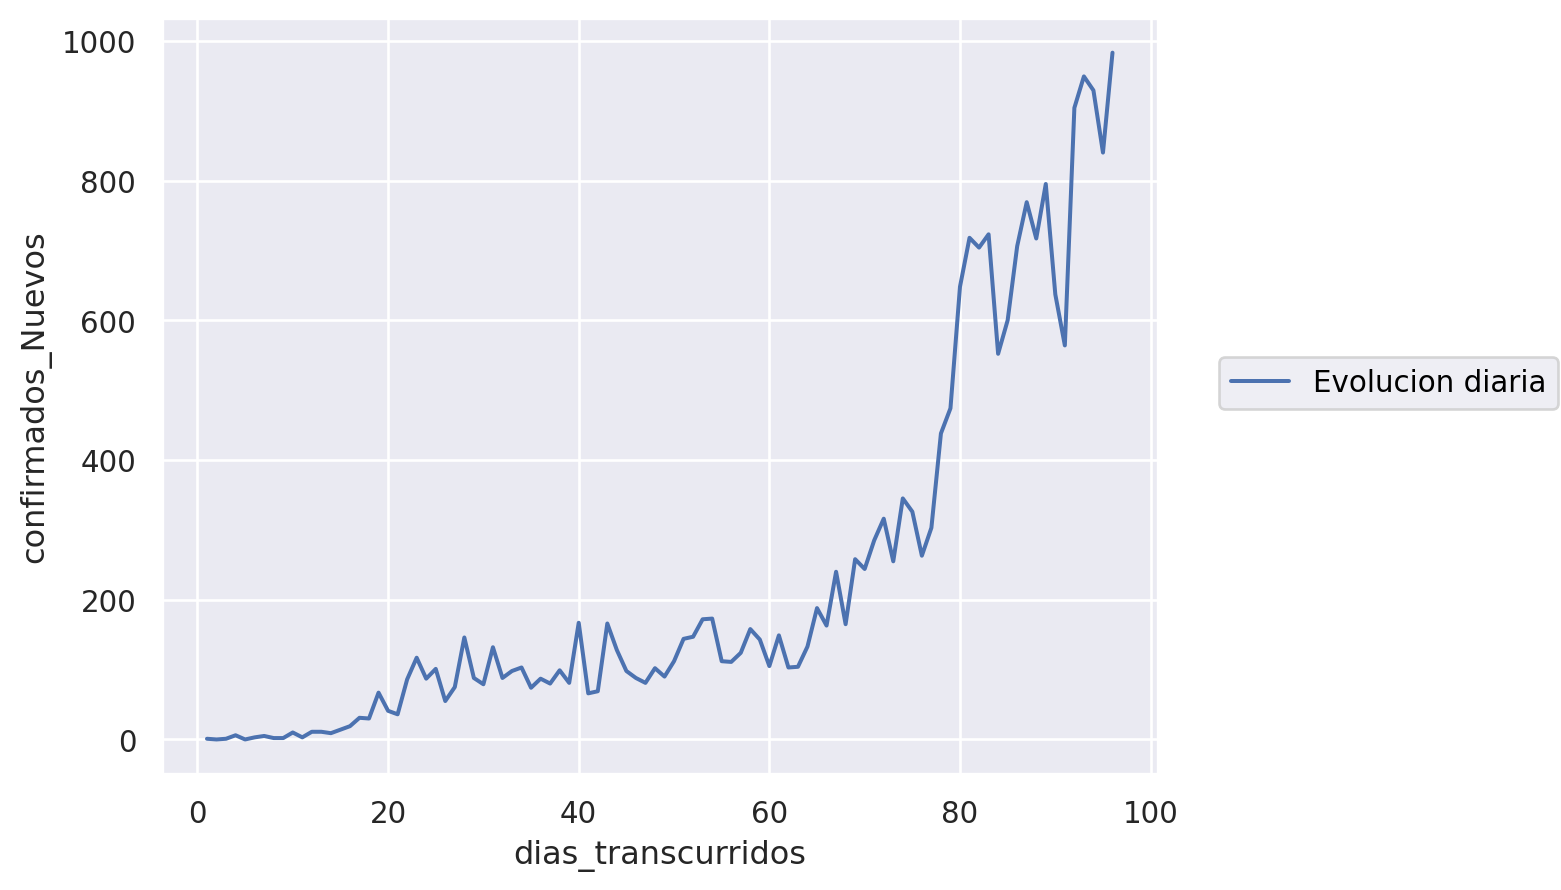

In [ ]:
# b) Ploteamos dias_transcurridos vs confirmados_nuevos

(
    so.Plot()
    .add(so.Line(), x = data["dias_transcurridos"], y = data["confirmados_Nuevos"], label = "Evolucion diaria")
)

 ### c) Armar modelo de regresion que permita explicar la evolucion de casos de coronavirus (Y) en funcion de los dias transcurridos (X).

 Para esto se proponen los siguientes modelos que no voy a copiar 

In [32]:
# Me pinto hacerlo con Linear Regression

# Dividimos el conj de datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(data["dias_transcurridos"], data["confirmados_Nuevos"], test_size=0.2, random_state=42)

modelo = linear_model.LinearRegression()
modelo.fit(X_train.to_frame(), y_train.to_frame())
y_pred = modelo.predict(X_test.to_frame())
sqecm = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("raiz de ECM: ", sqecm)
print("R2 ", r2)

raiz de ECM:  127.8344462288248
R2  0.7632864376587793


#### i) Armamos modelo de regresion lineal de orden 2. (Seria regresion ridge?)

$$Y = b +  w_{0} X + w_{1}X^{2} $$

#### ii) Armamos el siguiente modelo

$$Y = b + w_{0}X^{w_{1}} $$